## FX Smile Calibration using SABR Model
### By Rishabb Suresh (rs6395)

#### Packages

In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from scipy.optimize import fsolve,root,least_squares
import six
import matplotlib.ticker as mtick

In [2]:
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Input Data

#### Market Data from question

In [3]:
market_df = pd.read_excel("C:/Users/Rishabb/Downloads/Market Data.xlsx")
market_df.Expiry = pd.to_datetime(market_df.Expiry)

#### Dictionary of Constants given

In [4]:
input_dict = {'USD IR' : 0.022,'BRL IR':0.065,'Spot':3.724,'Current Date':pd.to_datetime("01/15/2019")}
input_dict

{'USD IR': 0.022,
 'BRL IR': 0.065,
 'Spot': 3.724,
 'Current Date': Timestamp('2019-01-15 00:00:00')}

#### Calculating Time to Maturity in days/365

In [5]:
market_df["Tm"] = market_df.apply(lambda row: (row["Expiry"] - input_dict["Current Date"]).days/365,axis = 1)

In [6]:
market_df[['ATM','25d_RR','25d_BF']] = 0.01 * market_df[['ATM','25d_RR','25d_BF']]
market_df["25d_BF_tot"] = market_df["ATM"] + market_df["25d_BF"]

In [7]:
market_df

,Tenor,Expiry,ATM,25d_RR,25d_BF,Tm,25d_BF_tot
0,ON,2019-01-16,0.2098,0.0120,0.0015,0.002740,0.2113
1,1W,2019-01-22,0.1391,0.0130,0.0020,0.019178,0.1411
2,2W,2019-01-29,0.1375,0.0140,0.0020,0.038356,0.1395
3,1M,2019-02-15,0.1424,0.0150,0.0022,0.084932,0.1446
4,2M,2019-03-14,0.1384,0.0175,0.0027,0.158904,0.1411
5,3M,2019-04-15,0.1382,0.0200,0.0032,0.246575,0.1414
6,6M,2019-07-15,0.1382,0.0240,0.0043,0.495890,0.1425
7,1Y,2020-01-15,0.1394,0.0290,0.0055,1.000000,0.1449


### Model 

#### Getting ATM Strike 

In [8]:
def get_K_ATM(row):
    return (np.exp(-1*0.5 * (row["ATM"]**2) * row["Tm"]) * np.exp((input_dict["BRL IR"] - input_dict["USD IR"])* row["Tm"]) * input_dict["Spot"])

market_df["K_ATM"] = market_df.apply(lambda row : get_K_ATM(row),axis = 1)

#### Getting Butterfly Strikes 

In [9]:
def delta_to_K_call(delta,S,tm,rd,rf,sig):
    func = lambda tau : delta*S*np.exp(rd*tm) - tau * norm.cdf((np.log(np.exp((rd - rf)*tm) * S) - np.log(tau))/(sig*np.sqrt(tm)) - 0.5*(sig*np.sqrt(tm)))
    tau_initial_guess = S 
    tau_solution = fsolve(func, tau_initial_guess)
    return tau_solution 

def delta_to_K_put(delta,S,tm,rd,rf,sig):
    func = lambda tau : delta*S*np.exp(rd*tm) + tau * norm.cdf(-1*((np.log(np.exp((rd - rf)*tm) * S) - np.log(tau))/(sig*np.sqrt(tm)) - (0.5*sig*np.sqrt(tm))))
    tau_initial_guess = S
    tau_solution = fsolve(func, tau_initial_guess)
    return tau_solution

market_df["K_BFCall"] = market_df.apply(lambda row: delta_to_K_call(0.25,input_dict["Spot"],row["Tm"],input_dict["BRL IR"],input_dict["USD IR"],row["25d_BF_tot"])[0],axis = 1) 
market_df["K_BFPut"] = market_df.apply(lambda row: delta_to_K_put(-0.25,input_dict["Spot"],row["Tm"],input_dict["BRL IR"],input_dict["USD IR"],row["25d_BF_tot"])[0],axis = 1) 

In [10]:
market_df

,Tenor,Expiry,ATM,25d_RR,25d_BF,Tm,25d_BF_tot,K_ATM,K_BFCall,K_BFPut
0,ON,2019-01-16,0.2098,0.0120,0.0015,0.002740,0.2113,3.724214,3.752338,3.696775
1,1W,2019-01-22,0.1391,0.0130,0.0020,0.019178,0.1411,3.726381,3.776537,3.678341
2,2W,2019-01-29,0.1375,0.0140,0.0020,0.038356,0.1395,3.728795,3.799534,3.662193
3,1M,2019-02-15,0.1424,0.0150,0.0022,0.084932,0.1446,3.734408,3.845334,3.633319
4,2M,2019-03-14,0.1384,0.0175,0.0027,0.158904,0.1411,3.743831,3.894229,3.610881
5,3M,2019-04-15,0.1382,0.0200,0.0032,0.246575,0.1414,3.754843,3.945513,3.591263
6,6M,2019-07-15,0.1382,0.0240,0.0043,0.495890,0.1425,3.786288,4.067966,3.559530
7,1Y,2020-01-15,0.1394,0.0290,0.0055,1.000000,0.1449,3.850035,4.277074,3.536850


#### SABR Functions

#### Inverse Function to get delta from strike

In [11]:
def K_to_delta_call(K,S,tm,rd,rf,sig):
    d2 = (np.log(np.exp((rd - rf)*tm) * S) - np.log(K))/(sig*np.sqrt(tm)) - 0.5*(sig*np.sqrt(tm))
    return (np.exp(-rd*tm) * (K/S) * norm.cdf(d2))

def K_to_delta_put(K,S,tm,rd,rf,sig):
    d2 = (np.log(np.exp((rd - rf)*tm) * S) - np.log(K))/(sig*np.sqrt(tm)) - 0.5*(sig*np.sqrt(tm))
    return (-1*np.exp(-rd*tm) * (K/S) * norm.cdf(-d2))    

#### Function to calculate Black Scholes FX Options premia

In [12]:
def Call_BS(sig,K,S,tm,rd,rf):
    d1 = (np.log(np.exp((rd - rf)*tm) * S) - np.log(K))/(sig*np.sqrt(tm)) + (0.5*sig*np.sqrt(tm))
    d2 = (np.log(np.exp((rd - rf)*tm) * S) - np.log(K))/(sig*np.sqrt(tm)) - (0.5*sig*np.sqrt(tm))
    
    BS_Call = np.exp(-rf*tm)*S*norm.cdf(d1) - np.exp(-rd*tm)*K*norm.cdf(d2)
    return BS_Call
    
def Put_BS(sig,K,S,tm,rd,rf):
    d1 = ((np.log(np.exp((rd - rf)*tm) * S) - np.log(K))/(sig*np.sqrt(tm)) + (0.5*sig*np.sqrt(tm)))
    d2 = ((np.log(np.exp((rd - rf)*tm) * S) - np.log(K))/(sig*np.sqrt(tm)) - (0.5*sig*np.sqrt(tm)))
    
    BS_Put = np.exp(-rd*tm)*K*norm.cdf(-d2) - np.exp(-rf*tm)*S*norm.cdf(-d1)
    return BS_Put

#### Function to Calculate SABR Implied Volatility including varying Beta (for future use)

In [13]:
# def SABR_Implied_Vol(K,S,t,a,b,v,rho):

#     z = (v/a) * ((S*K)**((1-b)/2)) * np.log(S/K)
    
#     x = np.log((np.sqrt(1 - (2*rho*z) + z**2) + z - rho)/(1 - rho))
    
#     temp = (a / ( S*K**((1-b)/2)) * (1 + ((1-b)**2/24) * (np.log(S/K)**2) + ((1-b)**4)/1920 * (np.log(S/K)**4))) * (z/x) * (1 + (t * (((1-b)**2/24) * (a**2/(S*K)**(1-b)) + ((rho*b*v*a)/(4*(S*K)**((1-b)/2))) + ((2-3*rho**2)*v**2/24))))
    
#     return temp


#### Function to Calculate SABR Implied Volatility with constant Beta of 1 (as given in question)

In [14]:
def SABR_Implied_Vol(K,S,t,a,v,rho):
    F = np.exp(input_dict["BRL IR"]-input_dict["USD IR"])*S
  
    z = (v/a) * np.log(F/K)
    
    x = np.log((np.sqrt(1 - (2*rho*z) + z**2) + z - rho)/(1 - rho))
    
    temp = a * (z/x) * (1 + t * ((a*v*rho)/4 + ((2-3*rho**2)*(v**2)/24)))
    
    return temp

#### Running SABR Model for the 5 stated parameters (Alpha, Vega, Rho and Risk Reversal Put and Call Strikes)

In [15]:
def Parameters_Calculator(row):
    def SABR_Run(x):
        f = np.empty((5))    
        f[0] =  SABR_Implied_Vol(row["K_ATM"],input_dict["Spot"],row["Tm"],x[0],x[1],x[2]) - row["ATM"]   
        f[1] =  K_to_delta_call(x[3],input_dict["Spot"],row["Tm"],input_dict["BRL IR"],input_dict["USD IR"],SABR_Implied_Vol(x[3],input_dict["Spot"],row["Tm"],x[0],x[1],x[2])) - 0.25
        f[2] =  K_to_delta_put(x[4],input_dict["Spot"],row["Tm"],input_dict["BRL IR"],input_dict["USD IR"],SABR_Implied_Vol(x[4],input_dict["Spot"],row["Tm"],x[0],x[1],x[2])) + 0.25
        f[3] =  (SABR_Implied_Vol(x[3],input_dict["Spot"],row["Tm"],x[0],x[1],x[2]) - SABR_Implied_Vol(x[4],input_dict["Spot"],row["Tm"],x[0],x[1],x[2])) - row["25d_RR"]   
        f[4] =  ((Call_BS(market_df.iloc[-1]["25d_BF_tot"],market_df.iloc[-1]["K_BFCall"],input_dict["Spot"],market_df.iloc[-1]["Tm"],input_dict["BRL IR"],input_dict["USD IR"]) + Put_BS(market_df.iloc[-1]["25d_BF_tot"],market_df.iloc[-1]["K_BFPut"],input_dict["Spot"],market_df.iloc[-1]["Tm"],input_dict["BRL IR"],input_dict["USD IR"])) - (Call_BS(SABR_Implied_Vol(market_df.iloc[-1]["K_BFCall"],input_dict["Spot"],market_df.iloc[-1]["Tm"],x[0],x[1],x[2]),market_df.iloc[-1]["K_BFCall"],input_dict["Spot"],market_df.iloc[-1]["Tm"],input_dict["BRL IR"],input_dict["USD IR"]) + Put_BS(SABR_Implied_Vol(market_df.iloc[-1]["K_BFPut"],input_dict["Spot"],market_df.iloc[-1]["Tm"],x[0],x[1],x[2]),market_df.iloc[-1]["K_BFPut"],input_dict["Spot"],market_df.iloc[-1]["Tm"],input_dict["BRL IR"],input_dict["USD IR"])))
        return f
    bounds = ([0,0,-1,market_df.iloc[-1]["K_ATM"],0],[0.6,10,0.9999,2*market_df.iloc[-1]["K_ATM"],market_df.iloc[-1]["K_ATM"]])
    sol = least_squares(SABR_Run, [row["ATM"],0.5,0.4,market_df.iloc[-1]["K_BFCall"],market_df.iloc[-1]["K_BFPut"]],bounds = bounds)
    sol.x
    return sol.x


In [16]:
collect_list = market_df.apply(lambda row : Parameters_Calculator(row),axis = 1)

In [17]:
collect_list = np.transpose(np.asarray(collect_list.tolist()))
collect_list = collect_list.tolist()

In [18]:
market_df["Alpha_value"] = collect_list[0]
market_df["Vega_value"] = collect_list[1]
market_df["Rho_value"] = collect_list[2]
market_df["K_RR_Call"] = collect_list[3]
market_df["K_RR_Put"] = collect_list[4]
market_df[["Alpha_value","Vega_value","Rho_value","K_RR_Call","K_RR_Put"]] = market_df[["Alpha_value","Vega_value","Rho_value","K_RR_Call","K_RR_Put"]].round(4)

#### Calculating Butterfly and Risk Reversal Call and Put Volatilities

In [19]:
market_df["Vol_BF_Call"] = market_df.apply(lambda row: SABR_Implied_Vol(row["K_BFCall"],input_dict["Spot"],market_df.iloc[-1]["Tm"],row["Alpha_value"],row["Vega_value"],row["Rho_value"]) ,axis = 1)
market_df["Vol_BF_Put"] = market_df.apply(lambda row: SABR_Implied_Vol(row["K_BFPut"],input_dict["Spot"],market_df.iloc[-1]["Tm"],row["Alpha_value"],row["Vega_value"],row["Rho_value"]) ,axis = 1)
market_df["Vol_RR_Call"] = market_df.apply(lambda row: SABR_Implied_Vol(row["K_RR_Call"],input_dict["Spot"],market_df.iloc[-1]["Tm"],row["Alpha_value"],row["Vega_value"],row["Rho_value"]) ,axis = 1)
market_df["Vol_RR_Put"] = market_df.apply(lambda row: SABR_Implied_Vol(row["K_RR_Put"],input_dict["Spot"],market_df.iloc[-1]["Tm"],row["Alpha_value"],row["Vega_value"],row["Rho_value"]) ,axis = 1)


#### Calculation of 10-delta Strikes

In [20]:
def delta_to_K_call(delta,S,tm,rd,rf,row):
    func = lambda tau : delta*S*np.exp(rd*tm) - tau * norm.cdf((np.log(np.exp((rd - rf)*tm) * S) - np.log(tau))/(SABR_Implied_Vol(tau,input_dict["Spot"],market_df.iloc[-1]["Tm"],row["Alpha_value"],row["Vega_value"],row["Rho_value"])*np.sqrt(tm)) - 0.5*(SABR_Implied_Vol(tau,input_dict["Spot"],market_df.iloc[-1]["Tm"],row["Alpha_value"],row["Vega_value"],row["Rho_value"])*np.sqrt(tm)))
    tau_initial_guess = S 
    tau_solution = fsolve(func, tau_initial_guess)
    return tau_solution 

def delta_to_K_put(delta,S,tm,rd,rf,row):
    func = lambda tau : delta*S*np.exp(rd*tm) + tau * norm.cdf(-1*((np.log(np.exp((rd - rf)*tm) * S) - np.log(tau))/(SABR_Implied_Vol(tau,input_dict["Spot"],market_df.iloc[-1]["Tm"],row["Alpha_value"],row["Vega_value"],row["Rho_value"])*np.sqrt(tm)) - (0.5*SABR_Implied_Vol(tau,input_dict["Spot"],market_df.iloc[-1]["Tm"],row["Alpha_value"],row["Vega_value"],row["Rho_value"])*np.sqrt(tm))))
    tau_initial_guess = S
    tau_solution = fsolve(func, tau_initial_guess)
    return tau_solution

In [21]:
market_df["K_10_delta_Call"] = market_df.apply(lambda row: delta_to_K_call(0.10,input_dict["Spot"],row["Tm"],input_dict["BRL IR"],input_dict["USD IR"],row)[0],axis = 1)
market_df["K_10_delta_Put"] = market_df.apply(lambda row: delta_to_K_put(-0.10,input_dict["Spot"],row["Tm"],input_dict["BRL IR"],input_dict["USD IR"],row)[0],axis = 1)

### Final DataFrame

In [22]:
def matplotlib_table_layout(data, col_width=2.2, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

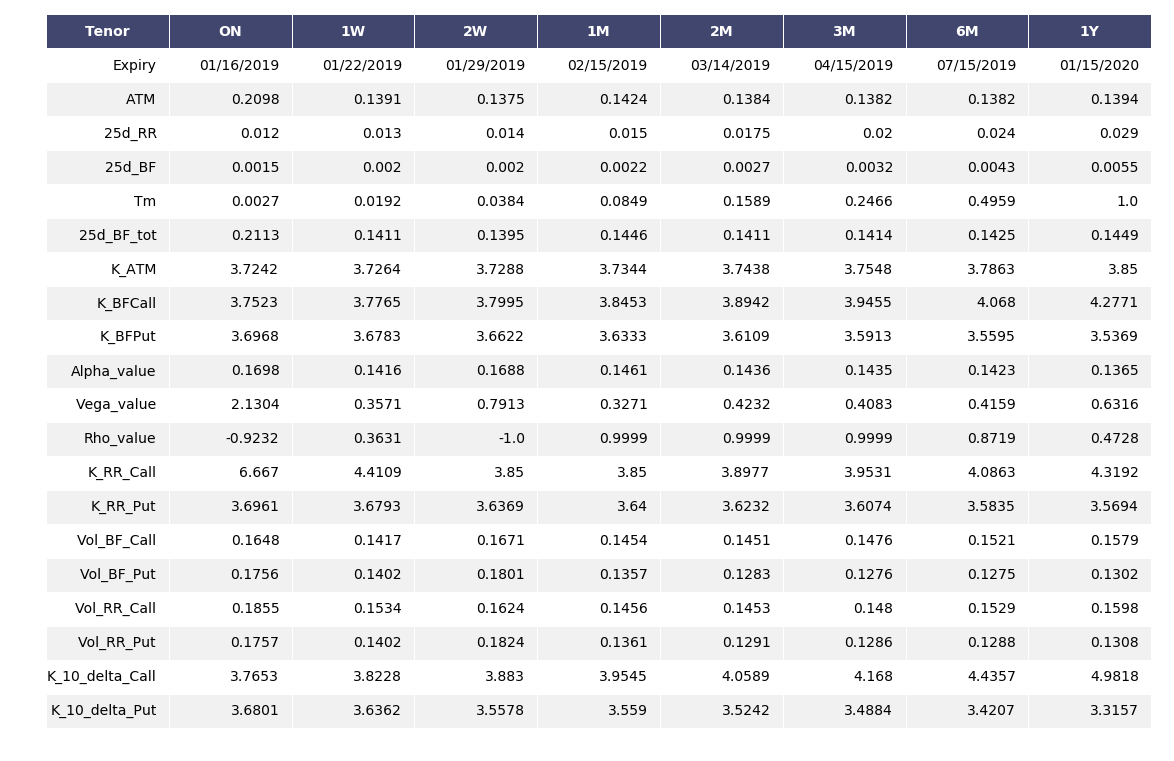

In [23]:
market_df.Expiry = market_df.Expiry.apply(lambda row: row.strftime("%m/%d/%Y"))
market_df_show = market_df.round(4).T.reset_index()
market_df_show.columns = market_df_show.iloc[0]
market_df_show.drop(market_df_show.index[0],inplace = True)
ax = matplotlib_table_layout(market_df_show)

### Volatility Smile Graph 

In [24]:
def collect_strikes_to_plot(row):
    return row[['K_BFPut','K_RR_Put','K_ATM','K_BFCall','K_RR_Call']].values.tolist()

def collect_vols_to_plot(row):
    return row[['Vol_BF_Put','Vol_RR_Put','ATM','Vol_BF_Call','Vol_RR_Call']].values.tolist()

strike_list = market_df.apply(lambda row:collect_strikes_to_plot(row),axis = 1)
vol_list = market_df.apply(lambda row:collect_vols_to_plot(row),axis = 1)
color_list = ['darkgray','darkred','saddlebrown','darkorange','forestgreen','teal','dodgerblue','darkviolet']

Text(0,0.5,'Volatility')

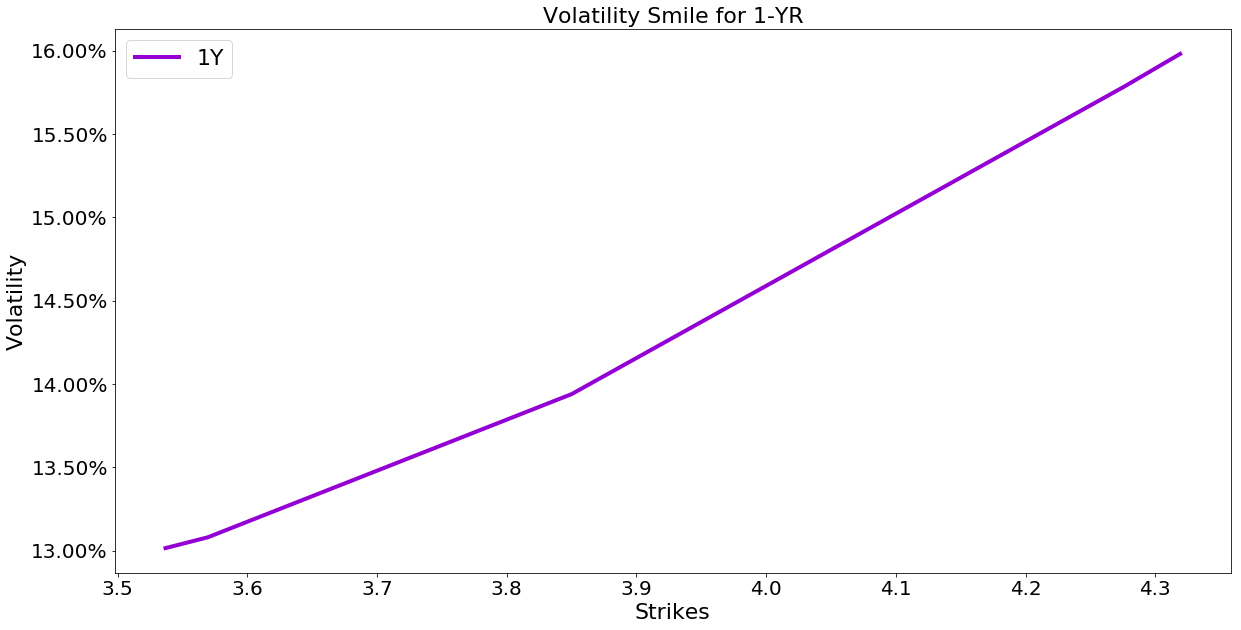

In [25]:
fig,ax = plt.subplots(figsize = (20,10))

ax.plot(strike_list[7],vol_list[7],linewidth = 4,color = color_list[7],label = market_df_show.columns[7+1])
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title("Volatility Smile for 1-YR")
ax.set_xlabel("Strikes")
ax.set_ylabel("Volatility")

Text(0,0.5,'Volatility')

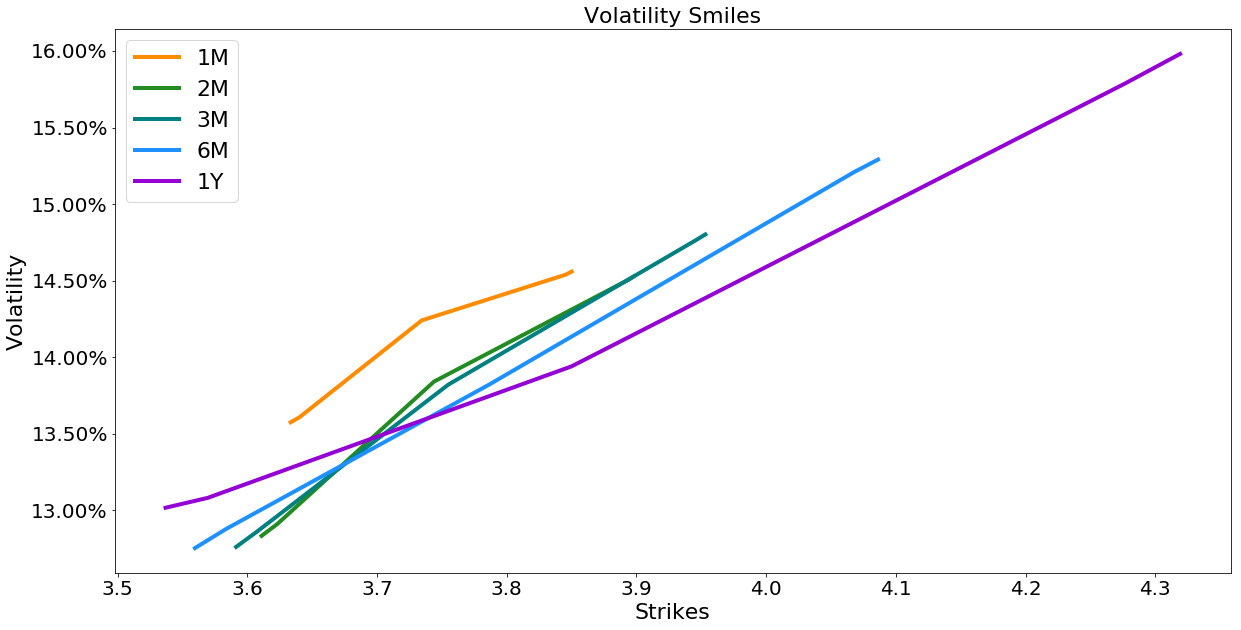

In [26]:
fig,ax = plt.subplots(figsize = (20,10))

for i in range(3,len(strike_list)):
    ax.plot(strike_list[i],vol_list[i],linewidth = 4,color = color_list[i],label = market_df_show.columns[i+1])
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title("Volatility Smiles")
ax.set_xlabel("Strikes")
ax.set_ylabel("Volatility")

### SUMMARY

The SABR Model was built for the Implied Volatility vs Strike for the range of a year from January 15, 2019.